In [1]:
import numpy as np
import sympy as sy
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.unit as unit
import simtk.openmm.app as app
from tqdm import tqdm

In [2]:
# Definiendo el toy model

n_particles = 1
system = mm.System()
mass   = 14.007 * unit.amu # masa del átomo N
system.addParticle(mass)

force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')
force.addGlobalParameter('K', 35 * unit.kilocalories_per_mole/unit.angstrom**2)
force.addGlobalParameter('Eo', 6.0 * unit.kilocalories_per_mole/unit.angstrom**2)
force.addGlobalParameter('C', 0.4 * 1/unit.angstrom**2)
force.addGlobalParameter('M', 0.25 * unit.kilocalories_per_mole/unit.angstrom)
force.addParticle(0, [])
system.addForce(force)

0

In [3]:
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
temperature = 300*unit.kelvin
pressure    = None

step_size       = 0.01*unit.picoseconds
num_steps       = 20000
saving_period   = 100
num_steps_saved = int(num_steps/saving_period)

friction   = 1.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, step_size)

platform_name = 'CPU'  
platform = mm.Platform.getPlatformByName(platform_name)

times      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positions  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocities = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energies   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energies    = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.nanometers

#initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

context = mm.Context(system, integrator, platform)
context.setPositions(initial_positions)
context.setVelocitiesToTemperature(temperature)

state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
times[0] = state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()[0]
    velocities[ii] = state.getVelocities()[0]
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 200/200 [00:05<00:00, 38.35it/s]


In [4]:
timesc      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
positionsc  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
velocitiesc = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
potential_energiesc = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
kinetic_energiesc = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

initial_positions  = positions[-1]

initial_velocities = velocities[-1]

state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)


for ii in tqdm(range(num_steps_saved)):
    context.getIntegrator().step(saving_period)
    state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    timesc[ii] = state.getTime()
    positionsc[ii] = state.getPositions()[0]
    velocitiesc[ii] = state.getVelocities()[0]
    kinetic_energiesc[ii]=state.getKineticEnergy()
    potential_energiesc[ii]=state.getPotentialEnergy()



100%|██████████| 200/200 [00:05<00:00, 37.41it/s]


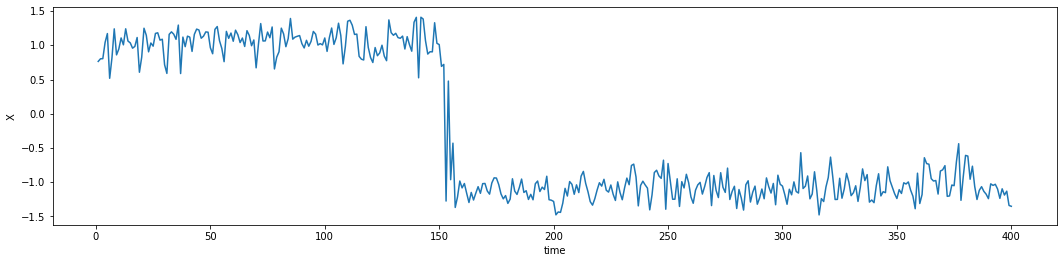

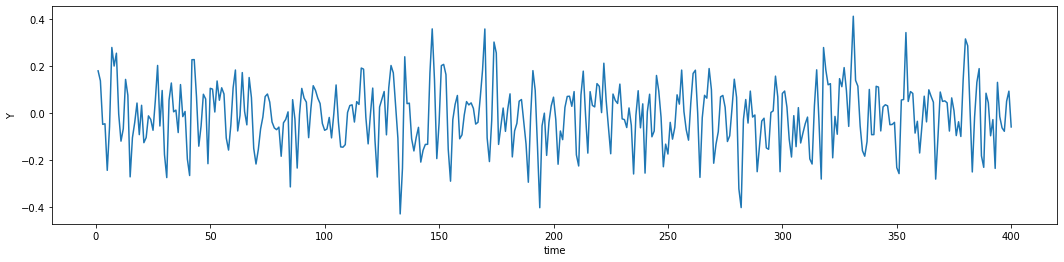

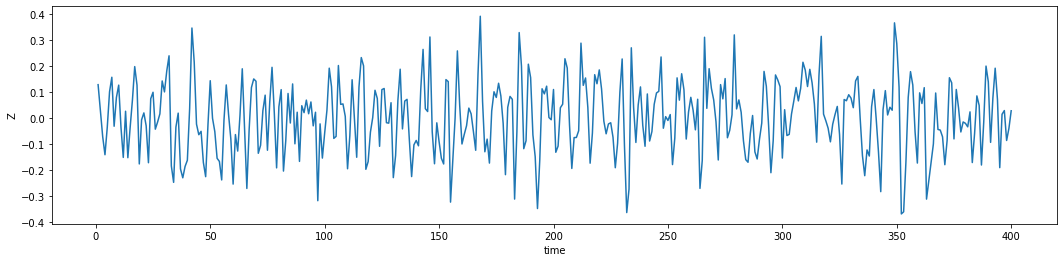

In [15]:
plt.rcParams['figure.figsize'] = 18, 4
for ii, ylabel in zip(range(3),['X','Y','Z']):
    plt.plot(timesb,positionsb[:,ii])
    plt.ylabel(ylabel)
    plt.xlabel('time')
    plt.show()

In [12]:
print(velocities[0])

[ 2.0152216 -4.655685   1.5471114] A/ps


In [18]:
timesb      = np.append(times,timesc)* unit.picoseconds
positionsb  = np.append(positions,positionsc, axis =0)* unit.angstroms
velocitiesb = np.append(velocities,velocitiesc, axis =0) * unit.angstroms/unit.picosecond
potential_energiesb = np.append(potential_energies,potential_energiesc, axis =0)* unit.kilocalories_per_mole
kinetic_energiesb = np.append(kinetic_energies, kinetic_energiesc, axis =0) * unit.kilocalorie_per_mole

In [3]:
replicas = [1,2,3,4,5]
temps = np.array([300,305,310,315,320])
kB = unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA

In [8]:
print(temps[0])

300 K


In [5]:
for jj in replicas:
    
    for ii in temps:
        temperature[jj] = ii * unit.kelvin
        pressure    = None

        step_size       = 0.01*unit.picoseconds
        num_steps       = 20000
        saving_period   = 100
        num_steps_saved = int(num_steps/saving_period)

        friction   = 1.0/unit.picosecond
        integrator = mm.LangevinIntegrator(temperature, friction, step_size)

        platform_name = 'CPU'  
        platform = mm.Platform.getPlatformByName(platform_name)

    times[jj]      = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.picoseconds)
    positions[jj]  = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms)
    velocities[jj] = unit.Quantity(np.zeros([num_steps_saved,3], np.float32), unit.angstroms/unit.picosecond)
    potential_energies[jj]   = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)
    kinetic_energies[jj]    = unit.Quantity(np.zeros([num_steps_saved], np.float32), unit.kilocalories_per_mole)

    initial_positions[jj]  = np.zeros([n_particles, 3], np.float32) * unit.nanometers

    #initial_velocities = None # Las velocidades serán adjudicadas aleatoriamente según la distribución Maxwell-Boltzmann del estado termodinámico

    context[jj] = mm.Context(system, integrator, platform)
    context[jj].setPositions(initial_positions[jj])
    context[jj].setVelocitiesToTemperature(temperature)

    state[jj] = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[jj[0]] = state.getTime()
    positions[jj[0]] = state.getPositions()[0]
    velocities[jj[0]] = state.getVelocities()[0]
    kinetic_energies[jj[0]]=state.getKineticEnergy()
    potential_energies[jj[0]]=state.getPotentialEnergy()

    for kk in tqdm(range(num_steps_saved)):
        context.getIntegrator().step(saving_period)
        state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
        times[jj[kk]] = state.getTime()
        positions[jj[kk]] = state.getPositions()[0]
        velocities[jj[kk]] = state.getVelocities()[0]
        kinetic_energies[jj[kk]]=state.getKineticEnergy()
        potential_energies[jj[kk]]=state.getPotentialEnergy()

NameError: name 'temperature' is not defined

In [15]:
print(temperature)

300 K
